# HW 1: Index Replication
Date: October 3rd, 2022
#### Group Members:
+ Nicolay Huarancay: nh23865
+ Ziyu (Louie) Wang: zw5565
+ Nevin Arimilli: na24887
+ Pengwei Wang: pw8574
***

#### Modules

In [1]:
#!pip install wrds

In [2]:
import wrds
import pandas as pd

#### Connection to WRDS
Using username and password

In [3]:
conn = wrds.Connection()

Enter your WRDS username [NICOLAY]:nicolayh
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


***

## Data

## Get Constituents

We get the list of stocks and dates they get in and out to the index

In [4]:
# Query: gvkeyx = '000005' is DJIA
q_const_hist = conn.raw_sql("""select *
                                 from comp.idxcst_his
                                where gvkeyx = '000005' """,
                            date_cols=['from','thru'])

In [5]:
q_const_hist.sort_values(by='from')

,gvkey,iid,gvkeyx,from,thru
21,005047,01,000005,1907-11-07,2018-06-25
22,005073,01,000005,1915-03-16,2009-06-07
39,009563,01,000005,1924-01-22,1999-10-31
1,001300,01,000005,1925-12-07,2008-02-18
41,010857,01,000005,1928-10-01,1999-10-31
20,004503,01,000005,1928-10-01,2020-08-28
23,005234,01,000005,1930-07-18,1999-10-31
19,004194,01,000005,1930-07-18,2004-04-07
14,003144,01,000005,1932-05-26,NaT
27,006066,01,000005,1932-05-26,NaT


In [50]:
q_const_hist.to_csv('01_df_constituents_hist.csv')

#### GVKEY List
Make a list of all the constituents of DJIA in the history (gvkey)

In [6]:
l_const_hist = q_const_hist['gvkey'].tolist()
filter_const_hist = ', '.join(["'"+str(x)+"'" for x in l_const_hist])

#### Get gvkey names

In [7]:
# Query
q_gvkey_names = conn.raw_sql("""select *
                                 from comp.names
                                where gvkey in ({}) """.format(filter_const_hist)
                            )
#q_gvkey_names

In [8]:
q_const_names = q_const_hist.merge(q_gvkey_names, left_on = 'gvkey', right_on='gvkey')
#.where(q_const_hist['thru'].isna())
#q_const_names

In [51]:
q_const_names.to_csv('02_df_const_names.csv')

## How many recontitutions were since 12-31-2011

In [9]:
d_changes = q_const_hist[q_const_hist['from']>'12/31/2011'][['from']].drop_duplicates().sort_values(by='from').reset_index(drop=True)
d_changes

,from
0,2012-09-24
1,2013-09-23
2,2015-03-19
3,2017-09-01
4,2018-06-26
5,2019-04-02
6,2020-08-31


In [10]:
len(d_changes)

7

## Reconstitution: annually
Changing the dates of reconstitution to the end of the year

In [12]:
import datetime as dt
def lastdayofyear(x):
    if pd.notnull(x):
        return dt.datetime(x.year,12,31)

# Updating reconstitution dates to the end of the year
q_const_hist_ann = q_const_hist.copy()
q_const_hist_ann['from'] = q_const_hist_ann['from'].apply(lastdayofyear)
q_const_hist_ann['thru'] = q_const_hist_ann['thru'].apply(lastdayofyear)
d_changes_ann = d_changes.copy()
d_changes_ann['from'] = d_changes['from'].apply(lastdayofyear)

In [13]:
q_const_names_ann = q_const_names.copy()
q_const_names_ann['from'] = q_const_names['from'].apply(lastdayofyear)
q_const_names_ann['thru'] = q_const_names['thru'].apply(lastdayofyear)
q_const_names_ann

,gvkey,iid,gvkeyx,from,thru,conm,tic,cusip,cik,sic,naics,gsubind,gind,year1,year2
0,001300,01,000005,2020-12-31,NaT,HONEYWELL INTERNATIONAL INC,HON,438516106,0000773840,9997,336413,20105010,201050,1950.0,2021.0
1,001300,01,000005,1925-12-31,2008-12-31,HONEYWELL INTERNATIONAL INC,HON,438516106,0000773840,9997,336413,20105010,201050,1950.0,2021.0
2,001356,01,000005,1959-12-31,2013-12-31,ALCOA INC,AA.3,013817507,None,3720,3364,15104010,151040,1950.0,2015.0
3,001447,01,000005,1982-12-31,NaT,AMERICAN EXPRESS CO,AXP,025816109,0000004962,6141,522210,40202010,402020,1960.0,2021.0
4,001487,01,000005,2004-12-31,2008-12-31,AMERICAN INTERNATIONAL GROUP,AIG,026874784,0000005272,6331,524126,40301030,403010,1972.0,2021.0
5,001581,01,000005,1939-12-31,2004-12-31,AT&T CORP,T.2,001957505,0000005907,4813,517110,50101020,501010,1950.0,2004.0
6,001602,01,000005,2020-12-31,NaT,AMGEN INC,AMGN,031162100,0000318154,2836,325414,35201010,352010,1982.0,2021.0
7,001690,01,000005,2015-12-31,NaT,APPLE INC,AAPL,037833100,0000320193,3663,334220,45202030,452020,1980.0,2021.0
8,002136,01,000005,2004-12-31,NaT,VERIZON COMMUNICATIONS INC,VZ,92343V104,0000732712,4812,517312,50101020,501010,1984.0,2021.0
9,002285,01,000005,1987-12-31,NaT,BOEING CO,BA,097023105,0000012927,3721,336411,20101010,201010,1950.0,2021.0


### DJIA replication contituents by dates

In [14]:
# Reference table
d_changes_from_thru = d_changes_ann.shift(1).append(d_changes_ann[-1:]).fillna(value=pd.to_datetime('12/30/2011')).reset_index(drop=True)
d_changes_from_thru['thru'] = d_changes_from_thru['from'].shift(-1)
d_changes_from_thru.fillna(value=pd.to_datetime('12/31/2099'), inplace=True)
#d_changes_from_thru

In [15]:

q_const_hist_2 = q_const_hist_ann.copy()
q_const_hist_2['thru'].fillna(value=pd.to_datetime('12/31/2099'), inplace=True)

df_constituents_dates = pd.DataFrame()

for i in range(len(d_changes_from_thru)):

    mask1 = (q_const_hist_2['from']<=d_changes_from_thru.iloc[i,0])
    mask2 = (q_const_hist_2['thru']>d_changes_from_thru.iloc[i,0])
    df_gvkey = q_const_hist_2[mask1 & mask2].sort_values(by='from').reset_index(drop=True)[['gvkey']]
    df_gvkey['from'] = d_changes_from_thru.iloc[i,0]
    df_gvkey['thru'] = d_changes_from_thru.iloc[i,1]
    df_constituents_dates = df_constituents_dates.append(df_gvkey)
    
df_constituents_dates

,gvkey,from,thru
0,005047,2011-12-30,2012-12-31
1,004503,2011-12-30,2012-12-31
2,006066,2011-12-30,2012-12-31
3,008762,2011-12-30,2012-12-31
4,003144,2011-12-30,2012-12-31
...,...,...,...
25,011264,2020-12-31,2099-12-31
26,034443,2020-12-31,2099-12-31
27,157855,2020-12-31,2099-12-31
28,001602,2020-12-31,2099-12-31


## Query Get Stocks prices

In [16]:
lst_gvkey = q_const_hist['gvkey'].unique().tolist()
filter_gvkey = ', '.join(["'"+str(x)+"'" for x in lst_gvkey])

lst_tic = q_const_names['tic'].unique().tolist()
filter_tic = ', '.join(["'"+str(x)+"'" for x in lst_tic])
#filter_tic

In [17]:
# Query
q_stocks = conn.raw_sql("""select gvkey, datadate, tic, cusip, conm, 
                                  prccd, ajexdi, prchd, prcld, prcod, prcstd, trfd, exchg
                             from comp.secd
                            where gvkey in ({})
                              and tic in ({})
                              and datadate >= '12/30/2011' """.format(filter_gvkey,filter_tic),
                        date_cols=['datadate'])

#q_stocks

In [18]:
q_stocks

,gvkey,datadate,tic,cusip,conm,prccd,ajexdi,prchd,prcld,prcod,prcstd,trfd,exchg
0,001356,2011-12-30,AA.3,013817507,ALCOA INC,8.65,0.333333,8.6500,8.5715,8.61,3.0,1.928478,11.0
1,001356,2012-01-03,AA.3,013817507,ALCOA INC,9.23,0.333333,9.2700,8.8900,8.94,3.0,1.928478,11.0
2,001356,2012-01-04,AA.3,013817507,ALCOA INC,9.45,0.333333,9.5000,9.1300,9.13,3.0,1.928478,11.0
3,001356,2012-01-05,AA.3,013817507,ALCOA INC,9.36,0.333333,9.4800,9.1900,9.33,3.0,1.928478,11.0
4,001356,2012-01-06,AA.3,013817507,ALCOA INC,9.16,0.333333,9.2500,9.0800,9.08,3.0,1.928478,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124876,004503,2022-09-26,XOM,30231G102,EXXON MOBIL CORP,83.98,1.000000,86.2200,83.8900,84.90,3.0,4.277632,11.0
124877,004503,2022-09-27,XOM,30231G102,EXXON MOBIL CORP,85.74,1.000000,86.9550,84.8100,85.61,3.0,4.277632,11.0
124878,004503,2022-09-28,XOM,30231G102,EXXON MOBIL CORP,88.86,1.000000,89.2999,85.9200,86.12,3.0,4.277632,11.0
124879,004503,2022-09-29,XOM,30231G102,EXXON MOBIL CORP,88.68,1.000000,89.3582,87.1300,88.18,3.0,4.277632,11.0


In [52]:
q_stocks.to_csv('03_df_stock_prices.csv')

# Replicating DJIA

#### Dates

In [19]:
# List of dates (10 years) from 12/30/2011
lst_dates_stocks = q_stocks[['datadate']].sort_values(by='datadate').drop_duplicates().reset_index(drop=True)

In [21]:
# Dataframe
df_djia_prices = pd.DataFrame(columns=['date','gvkey','prc','pr_aj_tr'])

for i in range(len(lst_dates_stocks.iloc[:2518])):

    # gvkey list date
    lst_gvkey_date = df_constituents_dates[(df_constituents_dates['from']<=lst_dates_stocks.iloc[i][0]) &
                                           (df_constituents_dates['thru']>lst_dates_stocks.iloc[i][0])]['gvkey'].tolist()
    
    if i>=1427 and i<=1509:
        lst_gvkey_date = list(map(lambda x: x.replace('004087','004060'), lst_gvkey_date)) # It's a rebranding
        
    mask1 = (q_stocks['datadate']==lst_dates_stocks.iloc[i][0]) ## Date
    mask2 = (q_stocks['gvkey'].isin(lst_gvkey_date)) ## List of stocks (30 Companies) in that date

    df_djia_aux = pd.DataFrame({'date':q_stocks[mask1 & mask2]['datadate'],
                                'gvkey':q_stocks[mask1 & mask2]['gvkey'],
                                'prc':q_stocks[mask1 & mask2]['prccd'],
                                'pr_aj_tr':(q_stocks[mask1 & mask2]['prccd']/q_stocks[mask1 & mask2]['ajexdi'])*q_stocks[mask1 & mask2]['trfd'],
                               })
    
    df_djia_prices = df_djia_prices.append(df_djia_aux)
    
    

In [22]:
df_djia_prices

,date,gvkey,prc,pr_aj_tr
0,2011-12-30,001356,8.65,50.043992
9335,2011-12-30,001447,47.17,108.357659
12042,2011-12-30,002285,73.35,130.453798
14748,2011-12-30,007647,5.56,14.461065
20160,2011-12-30,002817,90.60,162.968914
...,...,...,...,...
111160,2021-12-31,010903,502.14,608.704101
113866,2021-12-31,179534,216.71,238.203861
116572,2021-12-31,002136,51.96,350.567694
119279,2021-12-31,011264,52.16,95.679522


## Rebalancing (quarterly)

In [23]:
# Rebalancing dates
df_reb_dates = df_djia_prices[(df_djia_prices['date'].dt.month).isin([3,6,9,12])][['date']]\
                    .groupby([df_djia_prices['date'].dt.year,df_djia_prices['date'].dt.month]).max()

In [24]:
# Rebalancing - Keeping the weights at the end of each Quarter and mantaining those until the next update
df_djia_prices_2 = pd.DataFrame()
j = 0
for i in range(len(lst_dates_stocks.iloc[:2518])):
    if lst_dates_stocks.iloc[i][0] == df_reb_dates.iloc[j][0]:
        mask1 = (df_djia_prices['date']==lst_dates_stocks.iloc[i][0]) # quarterly balanced
        weights_aux = df_djia_prices[mask1][['gvkey']]
        weights_aux['weights'] = df_djia_prices[mask1]['prc']/df_djia_prices[mask1]['prc'].sum()
        weights_aux.set_index('gvkey',inplace=True)
        weights_aux
        j += 1
        
    mask2 = (df_djia_prices['date']==lst_dates_stocks.iloc[i][0]) # actual date
    df_djia_prices_aux = df_djia_prices[mask2].set_index('gvkey')
    df_djia_prices_aux['weights'] = weights_aux['weights']
    df_djia_prices_2 = df_djia_prices_2.append(df_djia_prices_aux)

df_djia_prices_2 = df_djia_prices_2.reset_index()

In [25]:
df_djia_prices_2

,gvkey,date,prc,pr_aj_tr,weights
0,001356,2011-12-30,8.65,50.043992,0.005358
1,001447,2011-12-30,47.17,108.357659,0.029220
2,002285,2011-12-30,73.35,130.453798,0.045438
3,007647,2011-12-30,5.56,14.461065,0.003444
4,002817,2011-12-30,90.60,162.968914,0.056123
...,...,...,...,...,...
75535,010903,2021-12-31,502.14,608.704101,0.091074
75536,179534,2021-12-31,216.71,238.203861,0.039305
75537,002136,2021-12-31,51.96,350.567694,0.009424
75538,011264,2021-12-31,52.16,95.679522,0.009460


## Returns and weights output

In [27]:
df_djia_prices_2['pr_aj_tr_lag1'] = df_djia_prices_2.groupby(['gvkey'])['pr_aj_tr'].shift(1)
df_djia_prices_2['return'] = (df_djia_prices_2['pr_aj_tr']/df_djia_prices_2['pr_aj_tr_lag1']) - 1
df_output_ret_weights = df_djia_prices_2

In [28]:
df_output_ret_weights

,gvkey,date,prc,pr_aj_tr,weights,pr_aj_tr_lag1,return
0,001356,2011-12-30,8.65,50.043992,0.005358,NaN,NaN
1,001447,2011-12-30,47.17,108.357659,0.029220,NaN,NaN
2,002285,2011-12-30,73.35,130.453798,0.045438,NaN,NaN
3,007647,2011-12-30,5.56,14.461065,0.003444,NaN,NaN
4,002817,2011-12-30,90.60,162.968914,0.056123,NaN,NaN
...,...,...,...,...,...,...,...
75535,010903,2021-12-31,502.14,608.704101,0.091074,611.480084,-0.004540
75536,179534,2021-12-31,216.71,238.203861,0.039305,239.478913,-0.005324
75537,002136,2021-12-31,51.96,350.567694,0.009424,352.524288,-0.005550
75538,011264,2021-12-31,52.16,95.679522,0.009460,95.367683,0.003270


## Replication

In [29]:
df_djia_prices_4 = pd.DataFrame()
df_djia_prices_3 = df_djia_prices_2.copy()
df_djia_prices_3['pr_w'] = df_djia_prices_3['weights']*df_djia_prices_3['prc']
df_djia_prices_3['pr_aj_tr_w'] = df_djia_prices_3['weights']*df_djia_prices_3['pr_aj_tr']
df_djia_prices_4['sum_price'] = df_djia_prices_3.groupby(['date'])['pr_w'].sum()
df_djia_prices_4['sum_pr_aj_tr'] = df_djia_prices_3.groupby(['date'])['pr_aj_tr_w'].sum()
df_djia_prices_4.reset_index(inplace=True)

df_djia_prices_4['sum_price_lag1'] = df_djia_prices_4['sum_price'].shift(1)
df_djia_prices_4['sum_pr_aj_tr_lag1'] = df_djia_prices_4['sum_pr_aj_tr'].shift(1)
df_djia_prices_4['price_pct'] = (df_djia_prices_4['sum_price']/df_djia_prices_4['sum_price_lag1']) - 1
df_djia_prices_4['return'] = (df_djia_prices_4['sum_pr_aj_tr']/df_djia_prices_4['sum_pr_aj_tr_lag1']) - 1

In [30]:
df_djia_replication = df_djia_prices_4[['date','sum_price','price_pct','return']]
df_djia_replication

,date,sum_price,price_pct,return
0,2011-12-30,77.929243,NaN,NaN
1,2012-01-03,79.036303,0.014206,0.016449
2,2012-01-04,79.063145,0.000340,0.000589
3,2012-01-05,78.898269,-0.002085,-0.002697
4,2012-01-06,78.481626,-0.005281,-0.005405
...,...,...,...,...
2513,2021-12-27,240.763441,0.010165,0.009147
2514,2021-12-28,241.341070,0.002399,0.003205
2515,2021-12-29,241.944503,0.002500,0.002499
2516,2021-12-30,241.342514,-0.002488,-0.002744


## Comparison

In [33]:
etf = pd.read_csv('ETF.csv')

In [34]:
etf['Instrument_Dates'] = pd.to_datetime(etf['Instrument_Dates'])

In [35]:
df_djia_comp = df_djia_replication.merge(etf, left_on = 'date', right_on = 'Instrument_Dates')
df_djia_comp

,date,sum_price,price_pct,return,Instrument_Dates,INDU_Index,DIA_US_Equity_Price,DJITR_Index_Return
0,2011-12-30,77.929243,NaN,NaN,2011-12-30,12217.56,-0.00547,-0.00566
1,2012-01-03,79.036303,0.014206,0.016449,2012-01-03,12397.38,0.01461,0.01476
2,2012-01-04,79.063145,0.000340,0.000589,2012-01-04,12418.42,0.00275,0.00196
3,2012-01-05,78.898269,-0.002085,-0.002697,2012-01-05,12415.70,-0.00016,-0.00022
4,2012-01-06,78.481626,-0.005281,-0.005405,2012-01-06,12359.92,-0.00339,-0.00392
...,...,...,...,...,...,...,...,...
2513,2021-12-27,240.763441,0.010165,0.009147,2021-12-27,36302.38,0.00991,0.00979
2514,2021-12-28,241.341070,0.002399,0.003205,2021-12-28,36398.21,0.00295,0.00264
2515,2021-12-29,241.944503,0.002500,0.002499,2021-12-29,36488.63,0.00234,0.00248
2516,2021-12-30,241.342514,-0.002488,-0.002744,2021-12-30,36398.08,-0.00211,-0.00248


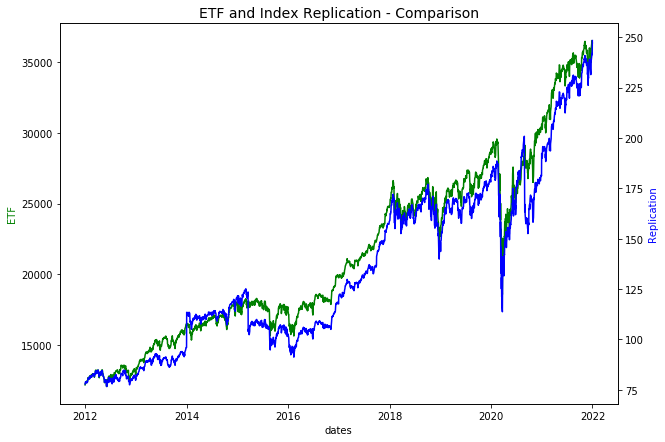

In [49]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
ax1.plot(df_djia_comp['date'], df_djia_comp['INDU_Index'], 'g-')
ax2.plot(df_djia_comp['date'], df_djia_comp['sum_price'], 'b-')

ax1.set_xlabel('dates')
ax1.set_ylabel('ETF', color='g')
ax2.set_ylabel('Replication', color='b')
plt.title('ETF and Index Replication - Comparison', fontsize = 14)

plt.show()

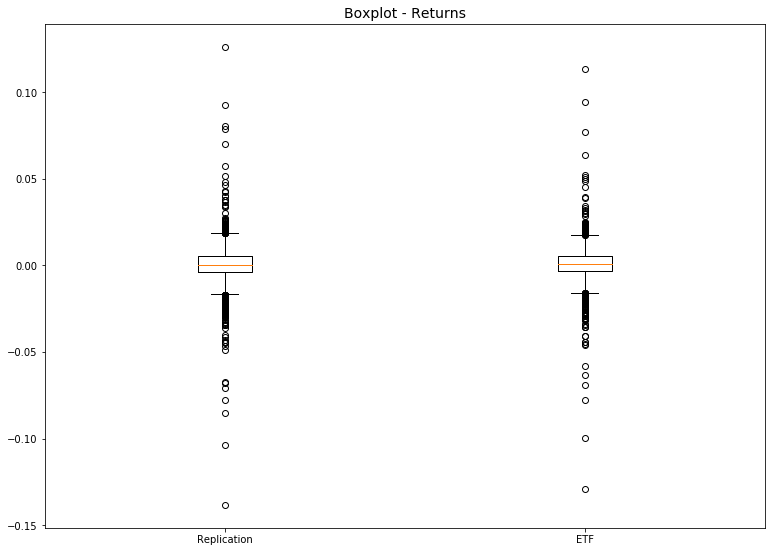

In [47]:
# BoxPlots
data = [df_djia_replication['return'][1:], df_djia_comp['DJITR_Index_Return']]

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xticks([1, 2], ['Replication', 'ETF'])
plt.title('Boxplot - Returns', fontsize = 14)

# show plot
plt.show()

# Metrics

#### ETF Average return

In [39]:
# Mean - ETF
etf['DJITR_Index_Return'].mean()

0.0003441913163812489

#### Index Replication Average Return

In [32]:
# Mean - replication
df_djia_replication['return'].mean()

0.00045359911775230216

#### R-squared

In [70]:
from sklearn.metrics import r2_score
# Close Price
temp = df_djia_comp.dropna()
r2_score((temp['INDU_Index']-temp['INDU_Index'].mean())/temp['INDU_Index'].std(), 
         (temp['sum_price']-temp['sum_price'].mean())/temp['sum_price'].std())

0.981631023635753

In [66]:
# Prices percentages
temp = df_djia_comp.dropna()
r2_score(temp['DIA_US_Equity_Price'], temp['price_pct'])

0.6019407147674178

In [67]:
# Return
temp = df_djia_comp.dropna()
r2_score(temp['DJITR_Index_Return'], temp['return'])

0.8890236925980498

#### Volatility

In [31]:
# Volatility - replication
df_djia_replication['return'].std()

0.011372271308899295

In [40]:
# Volatility - ETF
etf['DJITR_Index_Return'].std()

0.011686507209240346

#### Sharpe Ratio

In [60]:
# Sharpe Ratio - Index replication
rp = df_djia_comp['return'].mean()
rf = 0.00596
sigma = df_djia_comp['return'].std()

sharpe = (rp-rf)/sigma
sharpe

-0.48419534960783955

In [62]:
# Sharpe Ratio - ETF
rp = df_djia_comp['DJITR_Index_Return'].mean()
rf = 0.00596
sigma = df_djia_comp['DJITR_Index_Return'].std()

sharpe = (rp-rf)/sigma
sharpe

-0.5119712839090967

#### MSE

In [61]:
# MSE
from sklearn.metrics import mean_squared_error

temp = df_djia_comp.dropna()
mean_squared_error(temp['DJITR_Index_Return'], temp['return'])

1.2247816258600275e-05